In [1]:
import matplotlib.pyplot as plt
import os, json
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
datadir = "./results/"
search_files = [datadir + x for x in os.listdir(datadir) if "search" in x]
upload_files = [datadir + x for x in os.listdir(datadir) if "upload" in x]
gsi_search = [x for x in search_files if "gsi" in x]
glove25_gsi = [x for x in search_files if "glove-25" in x and "gsi" in x]
glove25_gsi = sorted(glove25_gsi, key=lambda x: int(x.split('-')[1]))
glove100_gsi = [x for x in search_files if "glove-100" in x and "gsi" in x]
glove100_gsi = sorted(glove100_gsi, key=lambda x: int(x.split('-')[1]))
deep96_gsi = [x for x in search_files if "deep" in x and "gsi" in x]
deep96_gsi = sorted(deep96_gsi, key=lambda x: int(x.split('-')[1]))
weaviate_files = [datadir + x for x in os.listdir(datadir) if "weaviate" in x]
weaviate_search = [x for x in weaviate_files if "search" in x]
qdrant_files = [datadir + x for x in os.listdir(datadir) if "qdrant" in x]
qdrant_search = [x for x in qdrant_files if "search" in x]

## Results

In [4]:
def parse_weav_search(fname):
    # filename parsing
    tmp = fname.split('-')
    if tmp[6].isnumeric():
        m, efc, dataset, dim = int(tmp[2]), int(tmp[4]), tmp[5], int(tmp[6])
    else:
        m, efc, dataset, dim = int(tmp[2]), int(tmp[4]), f"{tmp[5]}-{tmp[6]}", int(tmp[7])
    row = {'vdb': 'weaviate', 'm':m, 'efc': efc, 'dataset': dataset, 'dim': dim}

    
    # json file parse
    f = open(fname)
    tmp = json.load(f)
    row.update(tmp['params'].pop('vectorIndexConfig'))
    row.update(tmp['params'])
    row.update(tmp['results'])
    return row

In [5]:
def parse_gsi_search(fname):
    # filename parsing
    tmp = fname.split('-')
    # get nbits, dims, and dataset
    search_type = tmp[2]
    nbits, dim, dataset, m, efc, ef = [None] * 6
    # get hnsw params if available
    if search_type == "hnsw":
        if "-m-" not in fname:
            # set default values
            m, efc, ef = 32, 100, 100
        else:
            # pop 'm' and 'ef' values
            m, efc = tmp.pop(4), tmp.pop(5)
            # remove 'm' and 'ef'
            tmp.pop(3), tmp.pop(3)
    # get dataset and nbits params
    for i, x in enumerate(tmp):
        if x.isnumeric():
            if not nbits:
                nbits = int(x)
            elif not dim:
                dim = int(x)
                if tmp[i-1] == "image":
                    dataset = f"{tmp[i-2]}-{tmp[i-1]}"
                else:
                    dataset = f"{tmp[i-1]}"    
    row = {'vdb': 'gsi', 'search_type': search_type, 'nbits': nbits, 'dataset': dataset, 'dim': dim, 'm':m, 'efc': efc, 'ef': ef}
    # json file parse
    f = open(fname)
    tmp = json.load(f)
    # add json file data to row
    if '-m-' in fname:
        row.update(tmp['params'].pop('vectorIndexConfig'))
        row.update(tmp['params'])
    row.update(tmp['results'])
    return row

In [6]:
def parse_qdrant_search(fname):
    # filename parsing
    tmp = fname.split('-')
    if "rps" in fname or "mmap" in fname: 
        mode = tmp.pop(1)
    else: 
        mode = 'default'
    if tmp[6].isnumeric():
        m, efc, dataset, dim = int(tmp[2]), int(tmp[4]), tmp[5], int(tmp[6])
    else:
        m, efc, dataset, dim = int(tmp[2]), int(tmp[4]), f"{tmp[5]}-{tmp[6]}", int(tmp[7])
    row = {'vdb': 'qdrant', 'm':m, 'efc': efc, 'dataset': dataset, 'dim': dim, 'mode': mode}

    # json file parse
    f = open(fname)
    tmp = json.load(f)
    row.update(tmp['params'].pop('search_params'))
    row.update(tmp['params'])
    row.update(tmp['results'])
    return row

In [7]:
# create GSI search results dataframe
columns = ['vdb', 'search_type', 'nbits', 'dataset', 'dim', 'm', 'efc', 'ef', 'total_time', 'mean_time',\
             'mean_precisions', 'std_time', 'min_time', 'max_time', 'rps', 'p95_time', 'p99_time',\
             'precisions', 'latencies']
gsi_df = pd.DataFrame(columns=columns)
for fname in gsi_search:
    gsi_df.loc[len(gsi_df), :] = parse_gsi_search(fname)
gsi_df.fillna(np.nan)
gsi_df = gsi_df.astype({'m': float, 'efc': float, 'ef': float, 'dim': int, 'mean_precisions': float, 'mean_time': float})
gsi_df = gsi_df.astype({'m': 'Int64', 'efc': 'Int64', 'ef': 'Int64'})
gsi_df = gsi_df.sort_values(by=['search_type', 'dataset', 'dim', 'nbits']).reset_index(drop=True)

In [8]:
# create weaviate search results dataframe
columns = ['vdb', 'm', 'efc', 'ef', 'dataset', 'dim', 'parallel', 'total_time', 'mean_time',\
             'mean_precisions', 'std_time', 'min_time', 'max_time', 'rps', 'p95_time', 'p99_time',\
             'precisions', 'latencies']
weav_df = pd.DataFrame(columns=columns)
for fname in weaviate_search:
    weav_df.loc[len(weav_df)] = parse_weav_search(fname)
weav_df = weav_df.sort_values(by=['m', 'efc', 'dim', 'ef']).reset_index(drop=True)
weav_df.parallel.fillna(0, inplace=True)

In [10]:
# create qdrant search results dataframe
columns = ['vdb', 'm', 'efc', 'hnsw_ef', 'dataset', 'dim', 'parallel', 'total_time', 'mean_time',\
             'mean_precisions', 'std_time', 'min_time', 'max_time', 'rps', 'p95_time', 'p99_time',\
             'precisions', 'latencies']
qdrant_df = pd.DataFrame(columns=columns)
for fname in qdrant_search:
    qdrant_df.loc[len(qdrant_df)] = parse_qdrant_search(fname)
qdrant_df = qdrant_df.sort_values(by=['m', 'efc', 'dim', 'hnsw_ef']).reset_index(drop=True)

In [17]:
# create hnswlib search results dataframe
hnsw_files = [x for x in search_files if "hnswlib" in x]
hnsw_df = pd.DataFrame(columns=parse_weav_search(hnsw_files[0]).keys())
for fname in hnsw_files:
    row = parse_weav_search(fname)
    hnsw_df.loc[len(hnsw_df), :] = row
hnsw_df.vdb = 'hnswlib'
hnsw_df = hnsw_df.sort_values(['m', 'efc', 'ef', 'parallel']).reset_index(drop=True)

In [13]:
qdrant_df.to_csv('/mnt/nas1/vdbenchmark-results/qdrant-df.csv')
weav_df.to_csv('/mnt/nas1/vdbenchmark-results/weaviate-df.csv')
gsi_df.to_csv('/mnt/nas1/vdbenchmark-results/gsi-df.csv')
hnsw_df.to_csv('/mnt/nas1/vdbenchmark-results/hnswlib-df.csv')

### GSI HNSW

Text(0.5, 1.0, 'GSI HNSW Search / Latency vs Precision')

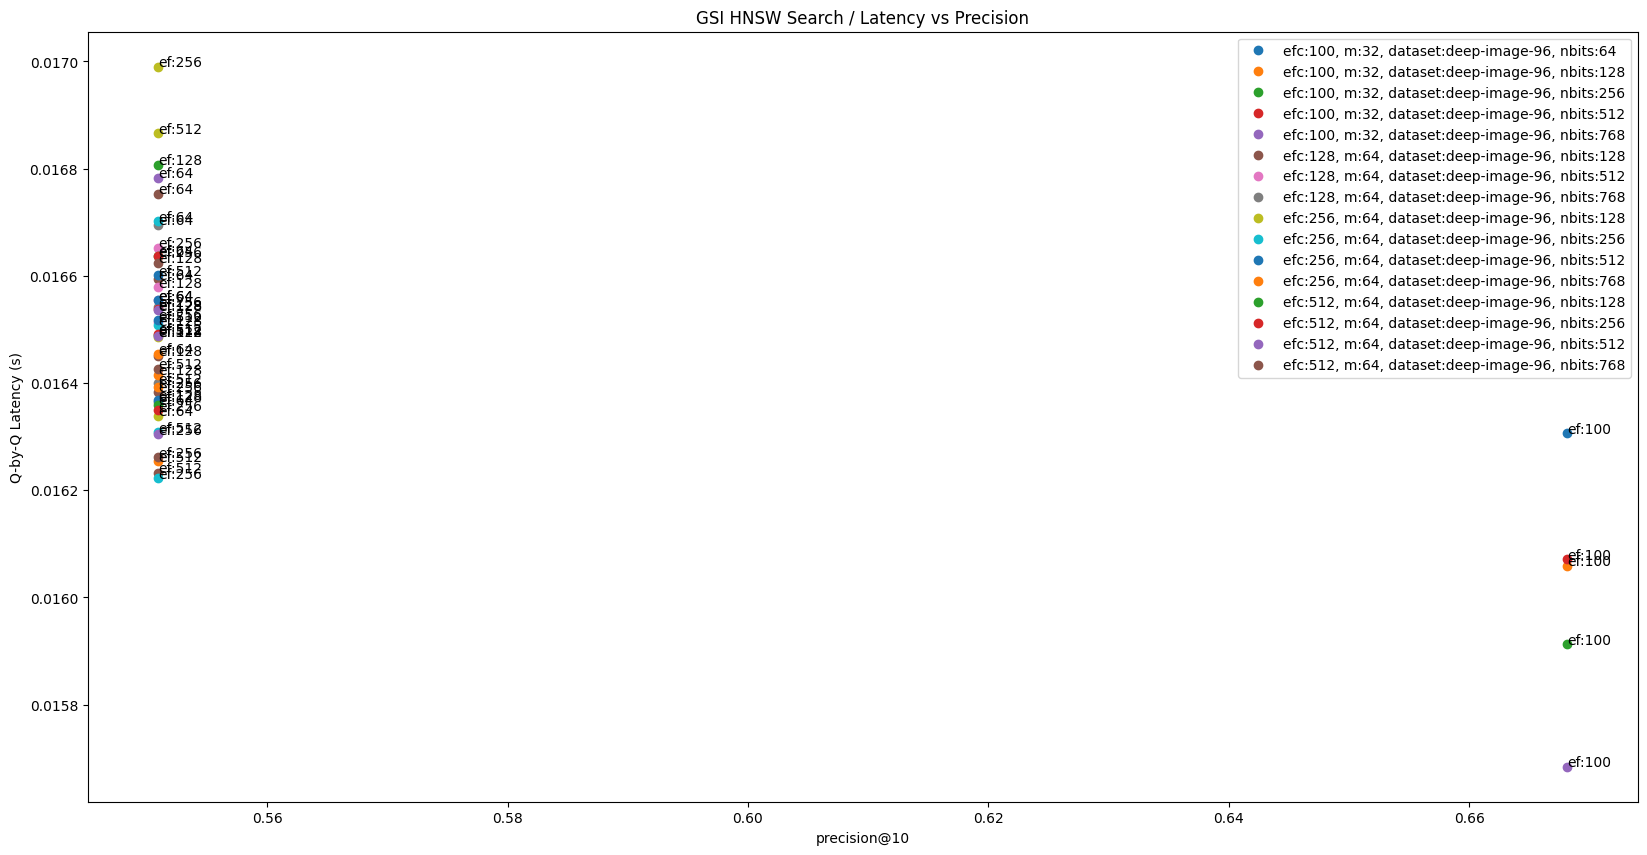

In [18]:
# TODO: colors are coherent
# seaborn color palettes

fig, ax = plt.subplots(figsize=(20,10))
tmp = gsi_df.copy()
tmp = tmp[tmp.search_type == 'hnsw']
tmp = tmp[tmp.dim == 96]
configs = tmp.groupby(by=['efc', 'm']).count().index.to_list()
for efc, m in configs:
    cp1 = tmp.copy()
    cp1 = cp1[(cp1.m == m) & (cp1.efc == efc)]
    for dset, dim in cp1.groupby(by=['dataset', 'dim']).count().index.to_list():
        cp2 = cp1.copy()
        cp2 = cp2[cp2.dim == dim]
        for bits in cp2.nbits.unique().tolist():
            cp3 = cp2[cp2.nbits == bits]
            if not len(cp3):
                continue
            plt.plot(cp3.mean_precisions, cp3.mean_time, 'o', label=f"efc:{efc}, m:{m}, dataset:{dset}-{dim}, nbits:{cp3.nbits.values[0]}")
            for a, z, y in zip(cp3.ef, cp3.mean_precisions, cp3.mean_time):
                plt.annotate(f"ef:{a}", (z,y))

ax.legend()
ax.set_xlabel("precision@10")
ax.set_ylabel("Q-by-Q Latency (s)")
ax.set_title("GSI HNSW Search / Latency vs Precision")

### GSI HNSW testing

In [40]:
import h5py
dataset = "gist-960-euclidean"
f = h5py.File(f"/home/jacob/vector-db-benchmark/datasets/{dataset}/{dataset}.hdf5")
np.save(f"/mnt/nas1/fvs_benchmark_datasets/{dataset}.npy", f['train'][:])
np.save(f"/mnt/nas1/fvs_benchmark_datasets/{dataset}-queries.npy", f['test'][:])
np.save(f"/mnt/nas1/fvs_benchmark_datasets/{dataset}-gt-inds.npy", f['neighbors'][:])
np.save(f"/mnt/nas1/fvs_benchmark_datasets/{dataset}-gt-dists.npy", f['distances'][:])

In [41]:
runs = []

In [42]:
import time
import swagger_client
from swagger_client.models import *
config = swagger_client.Configuration()
server = "192.168.99.40" #"192.168.99.33"
config.host = f"http://{server}:7760/v1.0"
config.verify_ssl = False
api_config = swagger_client.ApiClient(config)
alloc = "fvs-automation"
api_config.default_headers['allocationToken'] = alloc
datasets_apis = swagger_client.DatasetsApi(api_config)
search_apis = swagger_client.SearchApi(api_config)
utilities_apis = swagger_client.UtilitiesApi(api_config)
utilities_apis.controllers_utilities_controller_clear_cache(alloc)


importDataset=True
loadDataset=True

records = f"/mnt/nas1/fvs_benchmark_datasets/{dataset}.npy"
qpath = f"/mnt/nas1/fvs_benchmark_datasets/{dataset}-queries.npy"
# records = "/home/public/tmpQdrant.npy"
# qpath = "/home/public/oneVecQdrant.npy"
top = 10
search_type = "clusters"
nbits = 768
m = None
efc = None
ef_search = None
train_ind=True

# import dataset
if importDataset:
    dataset_id = datasets_apis.controllers_dataset_controller_import_dataset(
        ImportDatasetRequest(records=records, search_type=search_type, nbits=nbits, train_ind=train_ind, \
                             m_number_of_edges=m, ef_construction=efc),
        allocation_token=alloc
    ).dataset_id
else:
    dataset_id="tmp"
    
print("dataset id =", dataset_id, "\ntraining...")

status = datasets_apis.controllers_dataset_controller_get_dataset_status(
    dataset_id=dataset_id, allocation_token=alloc
).dataset_status
print(status)
while status != "completed":
    status = datasets_apis.controllers_dataset_controller_get_dataset_status(
        dataset_id=dataset_id, allocation_token=alloc
    ).dataset_status
    print('status currently:', status)
    time.sleep(3)

print("loading...")
loaded = datasets_apis.controllers_dataset_controller_load_dataset(
    LoadDatasetRequest(allocation_id=alloc, dataset_id=dataset_id, topk=top),
    allocation_token=alloc
)
print(loaded)
responses = []
queries = np.load(qpath)
for i, query in enumerate(queries):
    query = query.reshape(1, len(query))
    np.save("/home/public/oneVecQdrant.npy", query)
    response = search_apis.controllers_search_controller_search(
        SearchRequest(allocation_id=alloc, dataset_id=dataset_id, queries_file_path="/home/public/oneVecQdrant.npy", topk=top),
        alloc
    )
    responses.append(response)
    if i % 1000 == 0:
        print(f"query {i}")

dataset id = 87b27d5f-ebd9-4018-b3de-6b9daf898927 
training...
pending
status currently: pending
status currently: training
status currently: training
status currently: training
status currently: training
status currently: completed
loading...
{'status': 'ok'}
query 0


In [45]:
gt_inds = np.load(f"/mnt/nas1/fvs_benchmark_datasets/{dataset}-gt-inds.npy")
precisions = []
for i, resp in enumerate(responses):
    precision = len(np.intersect1d(resp.indices, gt_inds[i][:10])) / 10
    precisions.append(precision)
runs.append(np.mean(precisions))

In [46]:
runs

[0.0, 0.0]

## Weaviate Search

Text(0, 0.5, 'Q-by-Q latency (s)')

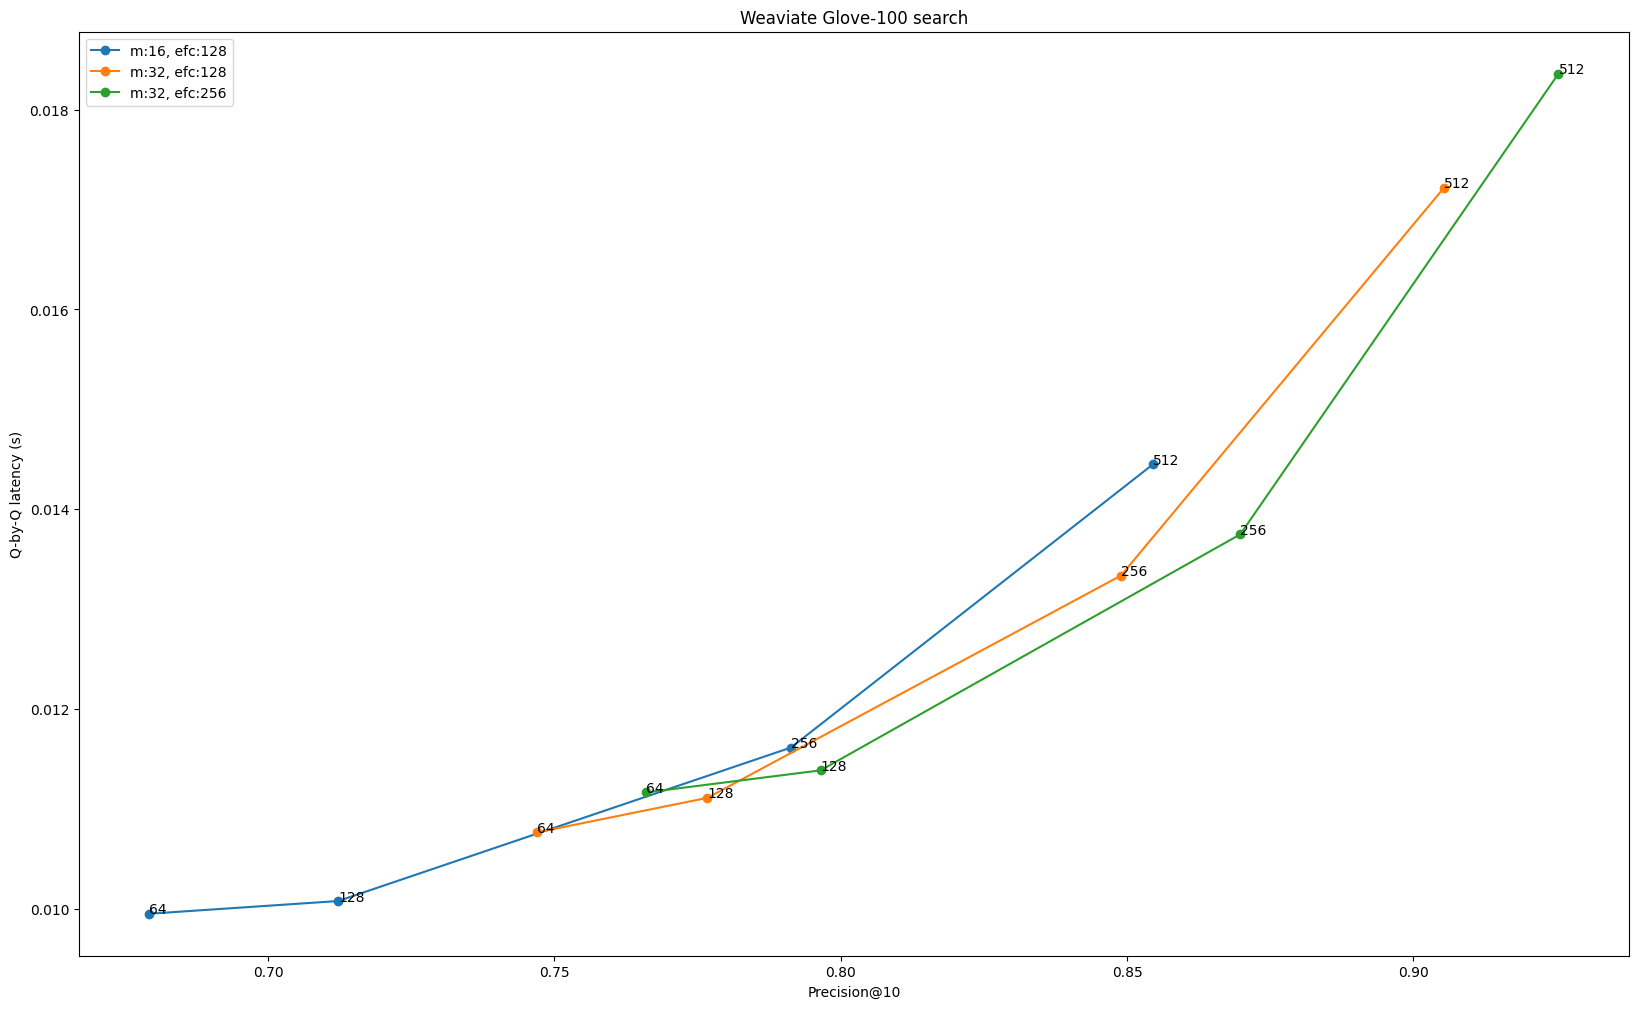

In [11]:
fig, ax = plt.subplots(figsize=(20, 12))
dataset = "glove"
dim = 100
parallels = [0]
tmp = weav_df.copy()
tmp = tmp[(tmp.dataset == dataset) & (tmp.dim == dim)]
tmp = tmp[tmp.parallel.isin(parallels)]
configs = tmp.groupby(['m', 'efc']).count().index.to_list()
for m, efc in configs:
    x = tmp[(tmp.efc == efc) & (tmp.m == m)].reset_index(drop=True)
    x = x.groupby('ef').aggregate({'mean_time': 'mean', 'mean_precisions': 'mean'})
    if not len(x):
        print(f"efc: {efc}, m: {m}")
        continue
    ax.plot(x.mean_precisions, x.mean_time, '-o', label=f"m:{m}, efc:{efc}")
    for _, row in x.iterrows():
        ax.annotate(f"{row.name}" , (row.mean_precisions, row.mean_time))

ax.legend()
ax.set_title("Weaviate Glove-100 search")
ax.set_xlabel("Precision@10")
ax.set_ylabel("Q-by-Q latency (s)")

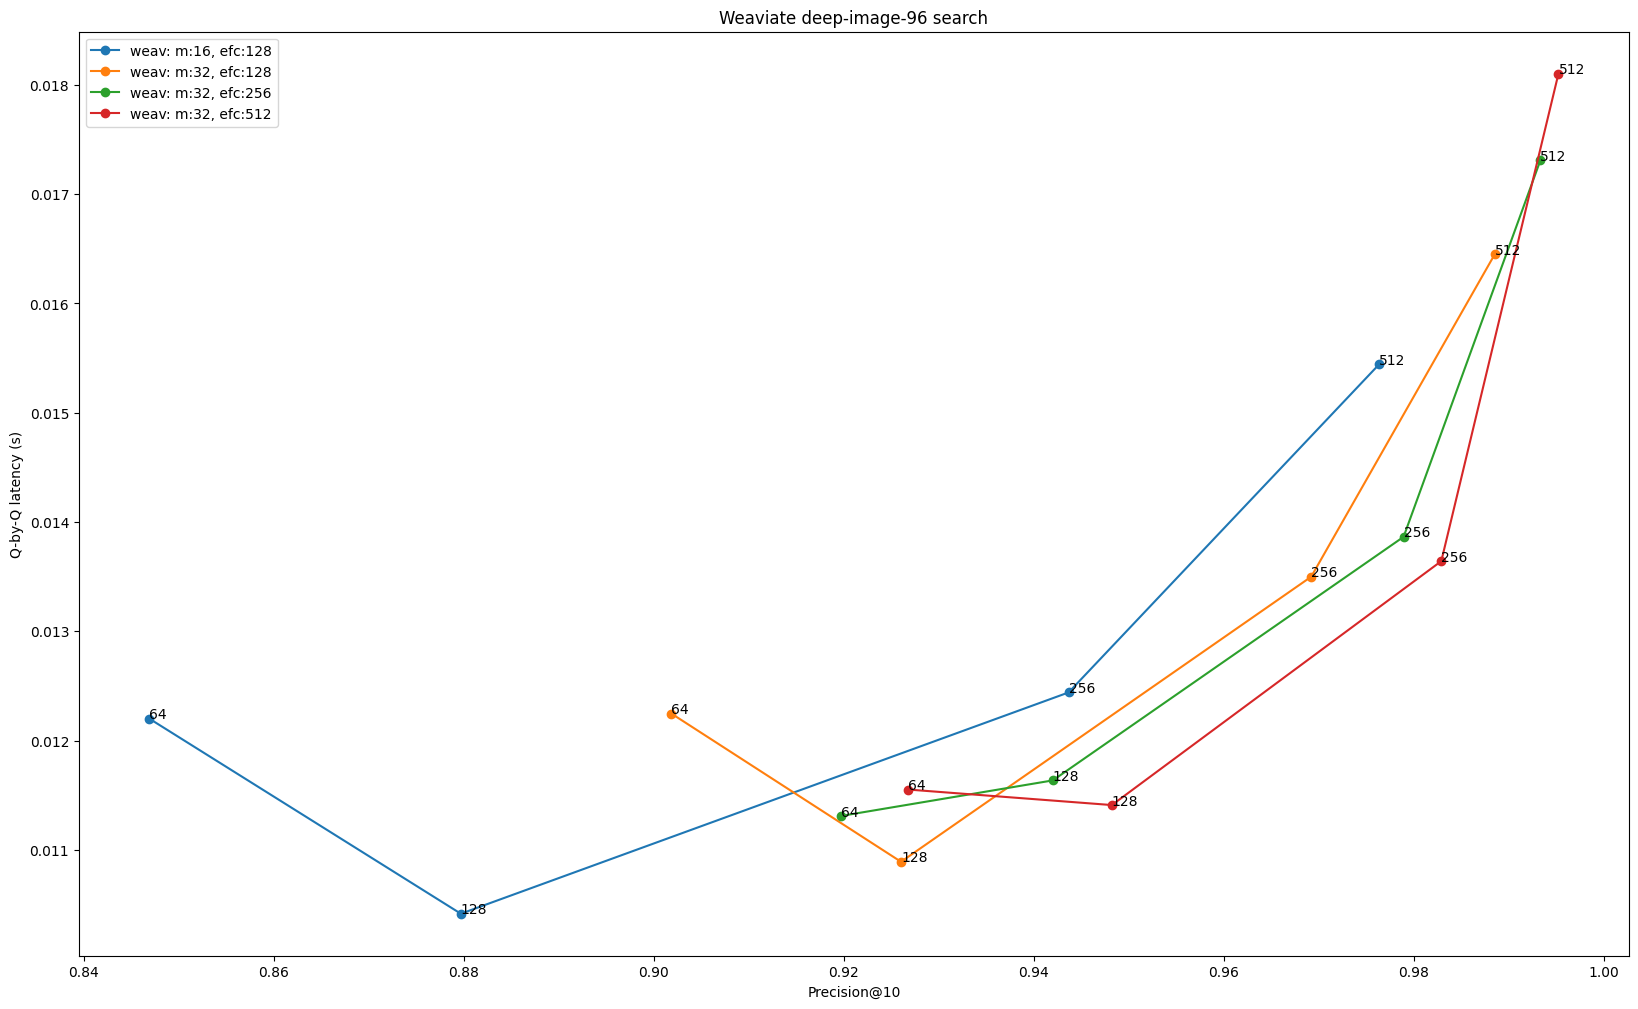

In [12]:
fig, ax = plt.subplots(figsize=(20, 12))
dataset = "deep-image"
dim = 96
parallels = [1]
tmp = weav_df.copy()
tmp = tmp[(tmp.dataset == dataset) & (tmp.dim == dim)]
tmp = tmp[tmp.parallel.isin(parallels)]
configs = tmp.groupby(['m', 'efc']).count().index.to_list()
for m, efc in configs:
    x = tmp[(tmp.efc == efc) & (tmp.m == m)].reset_index(drop=True)
    # x = x.groupby('ef').aggregate({'mean_time': 'mean', 'mean_precisions': 'mean'})
    if not len(x):
        print(f"efc: {efc}, m: {m}")
        continue
    ax.plot(x.mean_precisions, x.mean_time, '-o', label=f"weav: m:{m}, efc:{efc}")
    for _, row in x.iterrows():
        ax.annotate(f"{row.ef}" , (row.mean_precisions, row.mean_time))

ax.legend()
ax.set_title("Weaviate deep-image-96 search")
ax.set_xlabel("Precision@10")
ax.set_ylabel("Q-by-Q latency (s)")
fig.show()

### Qdrant

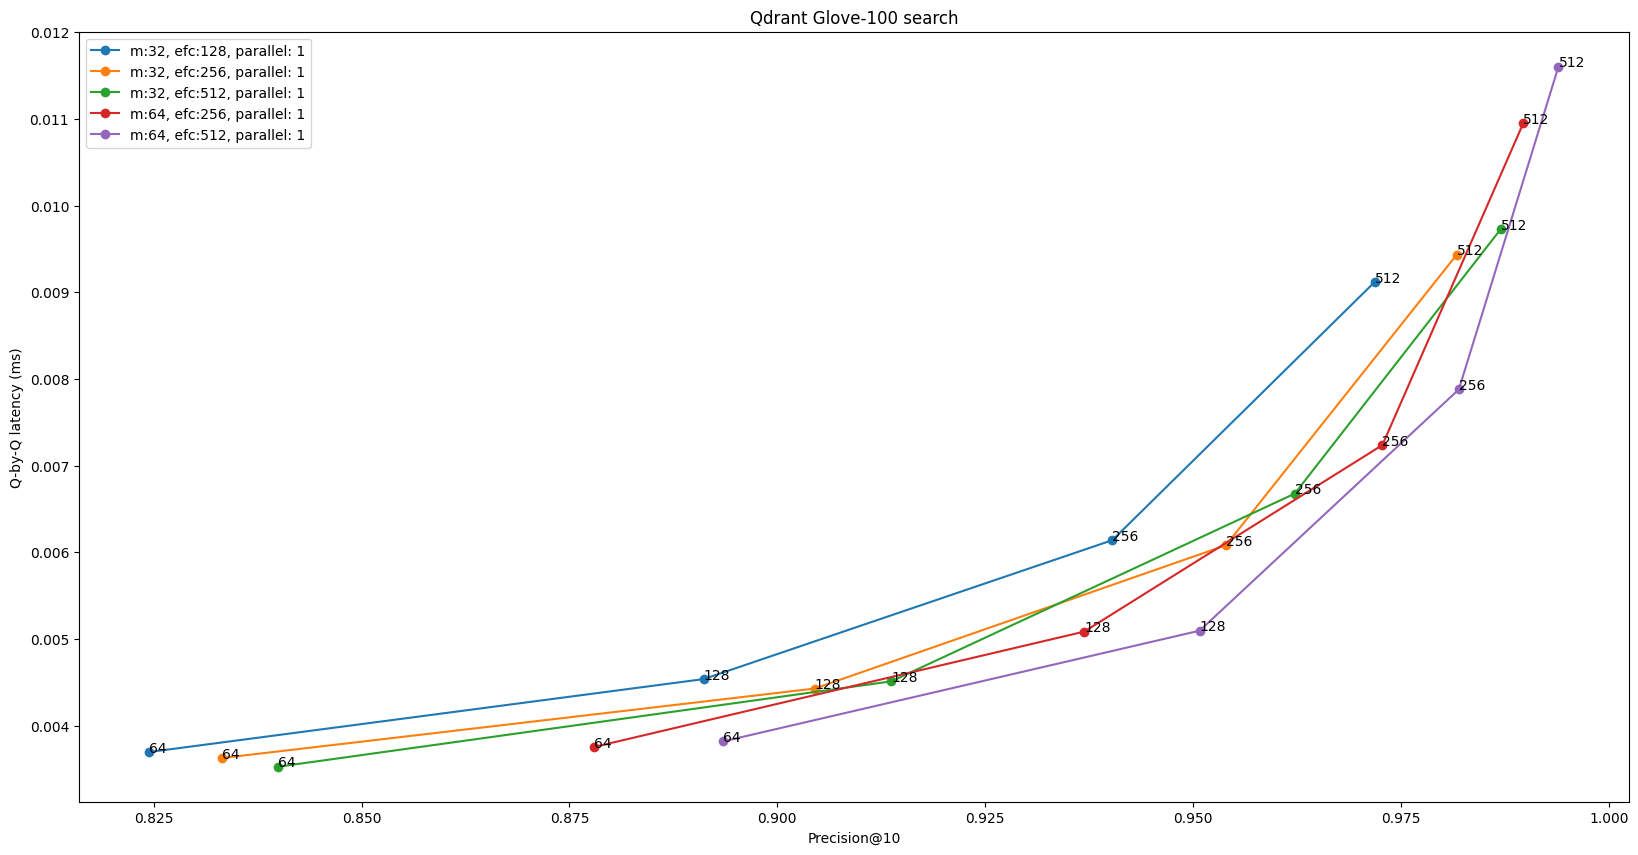

In [27]:
fig, ax = plt.subplots(figsize=(20,10))
parallels = [1]
dims = 100
tmp = qdrant_df.copy()
tmp = tmp[(tmp.dim == dims) & (tmp.parallel.isin(parallels))]
configs = tmp.groupby(by=['m', 'efc']).count().index.to_list()

for m, efc in configs:
    for parallel in parallels:
        x = tmp[(tmp.m == m) & (tmp.efc == efc) & (tmp.parallel == parallel)]
        plt.plot(x.mean_precisions, x.mean_time, '-o', label = f"m:{m}, efc:{efc}, parallel: {parallel}")
        for a, b, c in zip(x.hnsw_ef, x.mean_precisions, x.mean_time):
            plt.annotate(a, (b,c))
ax.legend()
ax.set_title("Qdrant Glove-100 search")
ax.set_xlabel("Precision@10")
ax.set_ylabel("Q-by-Q latency (ms)")
fig.show()

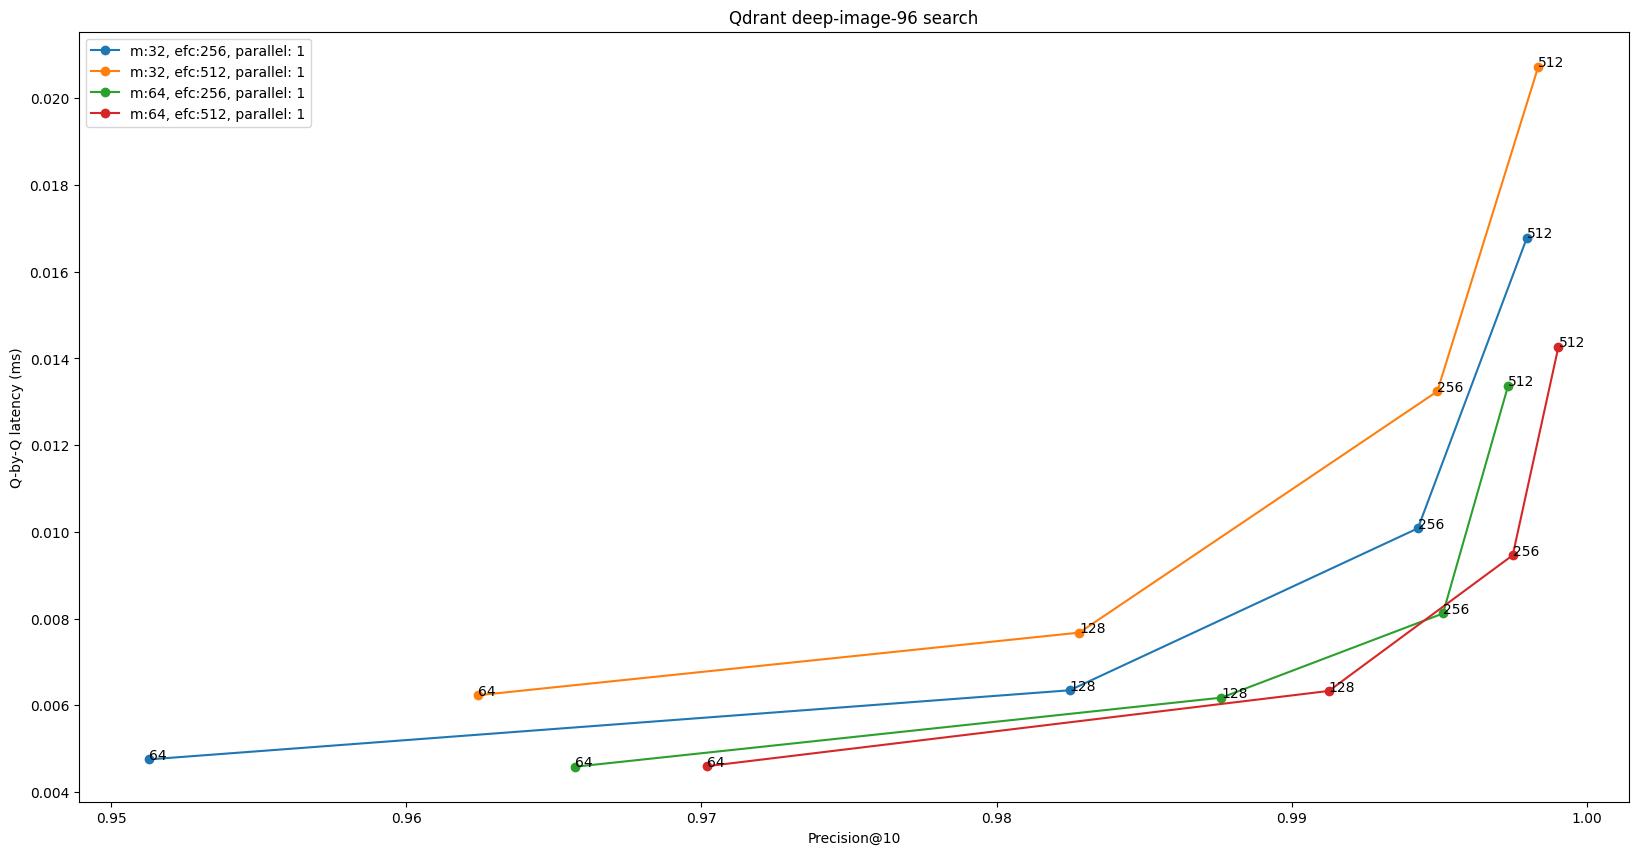

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
parallels = [1]
dims = 96
tmp = qdrant_df.copy()
tmp = tmp[(tmp.dim == dims) & (tmp.parallel.isin(parallels))]
configs = tmp.groupby(by=['m', 'efc']).count().index.to_list()

for m, efc in configs:
    for parallel in parallels:
        x = tmp[(tmp.m == m) & (tmp.efc == efc) & (tmp.parallel == parallel)]
        plt.plot(x.mean_precisions, x.mean_time, '-o', label = f"m:{m}, efc:{efc}, parallel: {parallel}")
        for a, b, c in zip(x.hnsw_ef, x.mean_precisions, x.mean_time):
            plt.annotate(a, (b,c))

ax.legend()
ax.set_title("Qdrant deep-image-96 search")
ax.set_xlabel("Precision@10")
ax.set_ylabel("Q-by-Q latency (ms)")
fig.show()

## HNSWLIB

In [14]:
hnsw_files = [x for x in search_files if "hnswlib" in x]
hnsw_df = pd.DataFrame(columns=parse_weav_search(hnsw_files[0]).keys())
for fname in hnsw_files:
    row = parse_weav_search(fname)
    hnsw_df.loc[len(hnsw_df), :] = row
hnsw_df.vdb = 'hnswlib'
hnsw_df = hnsw_df.sort_values(['m', 'efc', 'ef', 'parallel']).reset_index(drop=True)

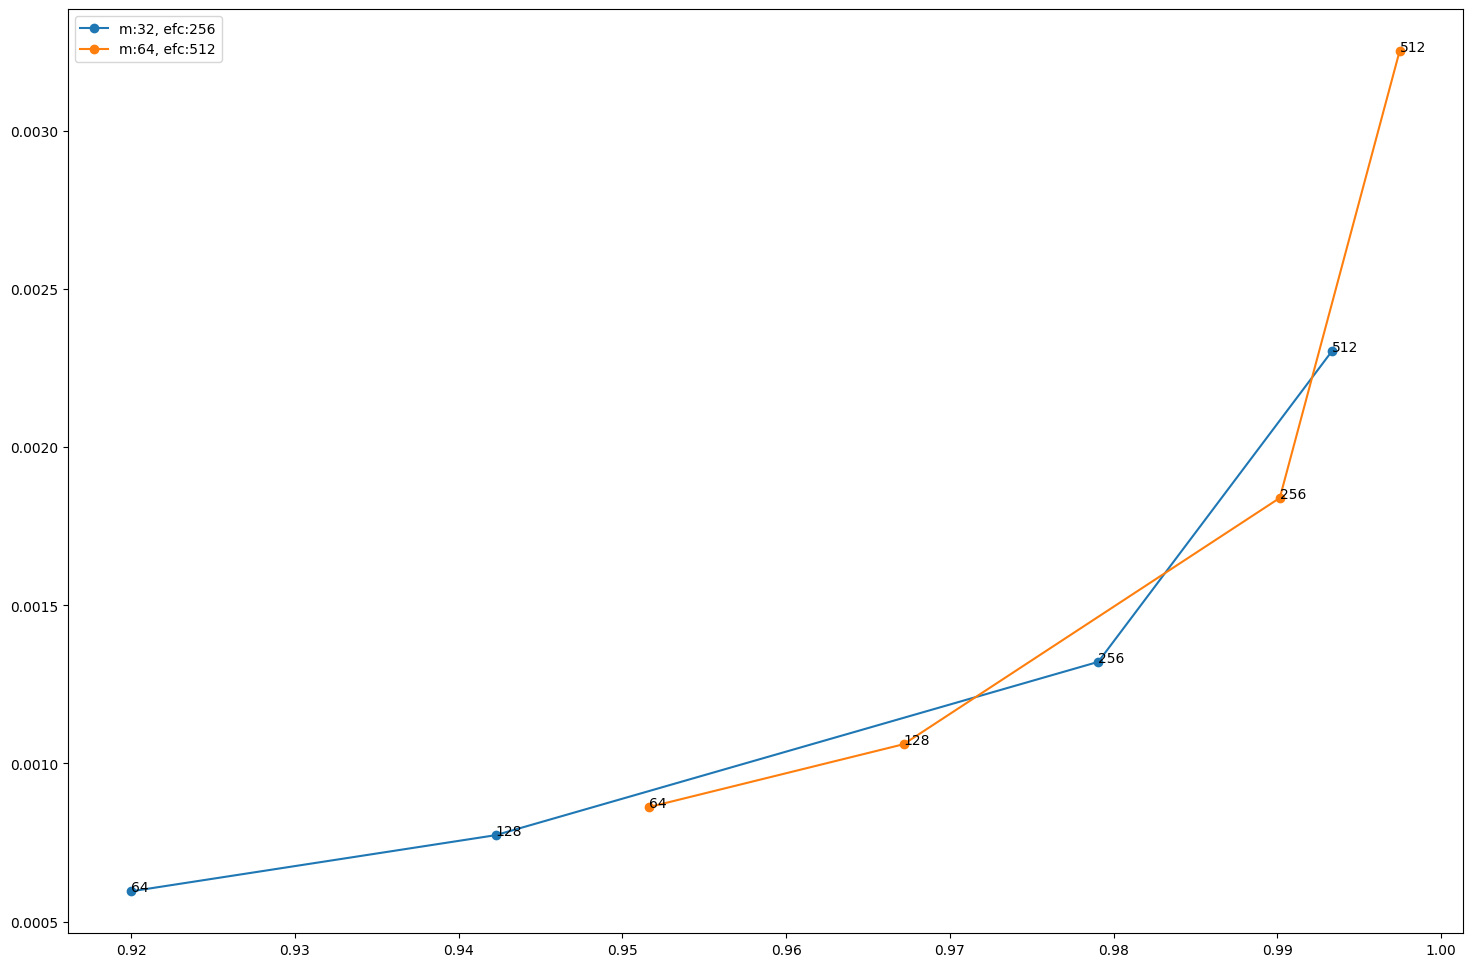

In [12]:
fig, ax = plt.subplots(figsize=(18,12))
parallels = [1]
dim = 96
configs = hnsw_df.groupby(['m', 'efc']).count().index.to_list()
for m, efc in configs:
    tmp = hnsw_df[(hnsw_df.m == m) & (hnsw_df.efc == efc) & (hnsw_df.parallel.isin(parallels)) & (hnsw_df.dim == dim)]
    plt.plot(tmp.mean_precisions, tmp.mean_time, '-o', label=f"m:{m}, efc:{efc}")
    for x,y,z in zip(tmp.mean_precisions, tmp.mean_time, tmp.ef):
        plt.annotate(z, (x,y))
ax.legend()
fig.show()

## all

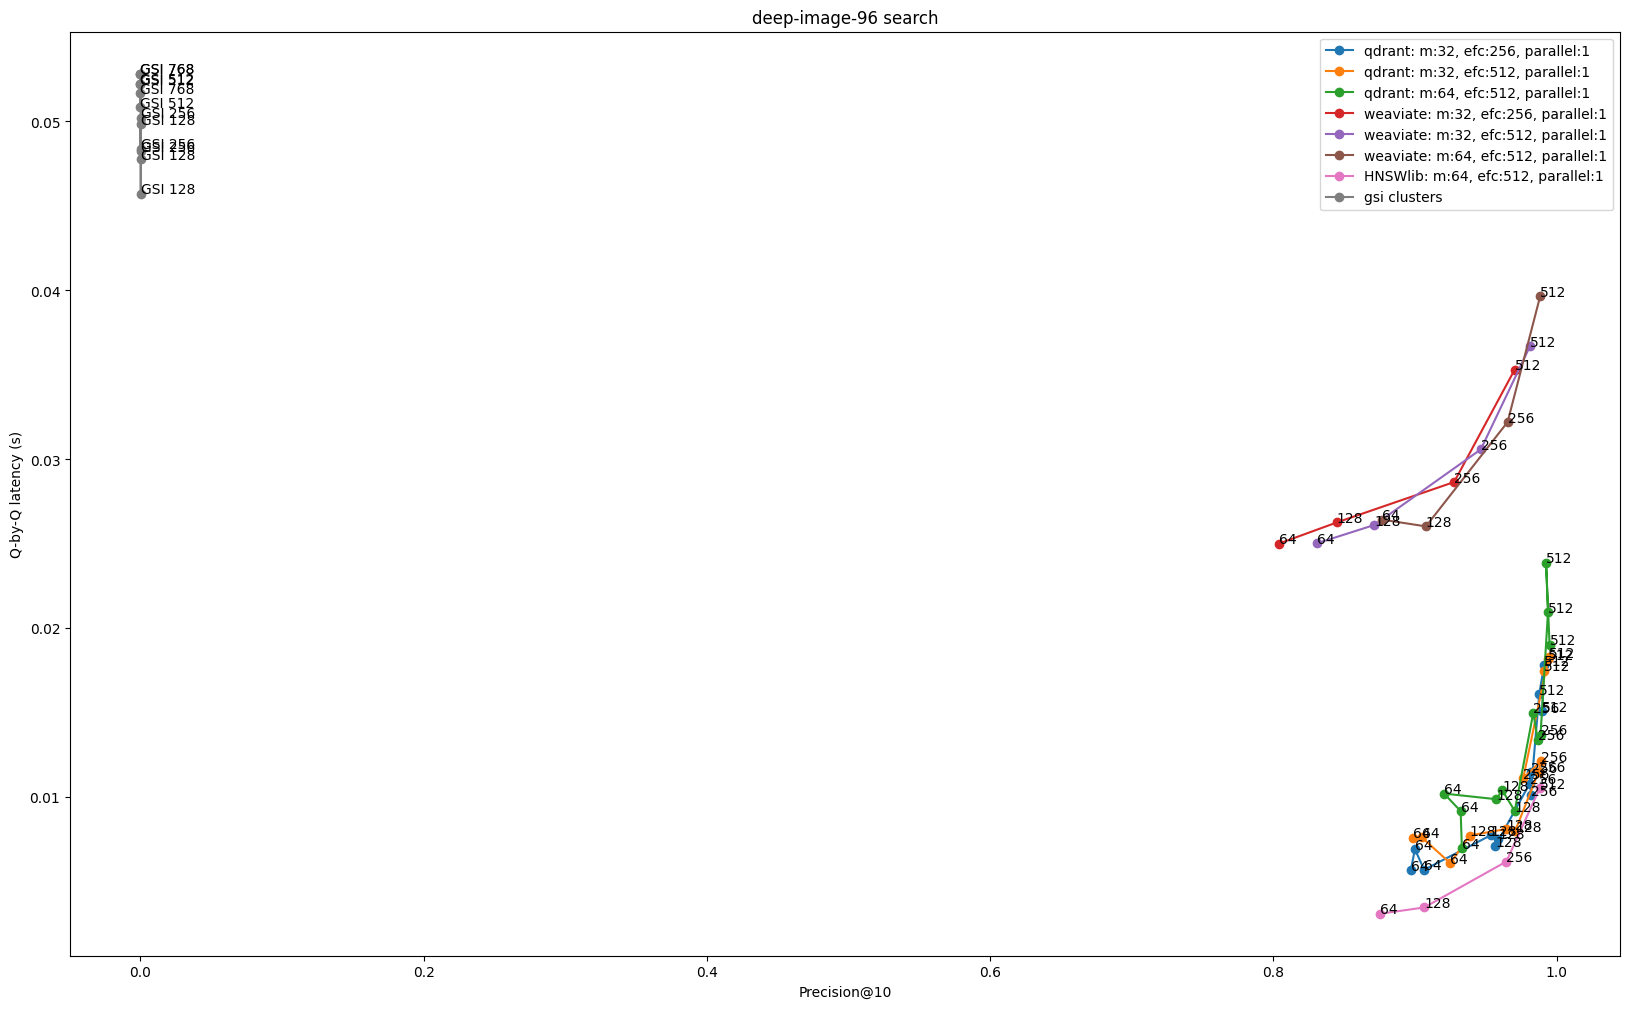

In [23]:
fig, ax = plt.subplots(figsize=(20,12))

# select parallels, dataset dimensions, and GSI search type
parallels = [1] # 1, 2, 4, 8, 100
dims = 96 # 25, 96, 100, 768, 960
search_type = ["hnsw", "clusters"]

tmp_qdrant = qdrant_df.copy()
tmp_qdrant = tmp_qdrant[(tmp_qdrant.dim == dims) & (tmp_qdrant.parallel.isin(parallels))]
qdrant_configs = tmp_qdrant.groupby(by=['m', 'efc']).count().index.to_list()

tmp_weav = weav_df.copy()
tmp_weav = tmp_weav[(tmp_weav.dim == dims) & (tmp_weav.parallel.isin(parallels))]
weav_configs = tmp_weav.groupby(['m', 'efc']).count().index.to_list()

tmp_hnsw = hnsw_df.copy()
tmp_hnsw = tmp_hnsw[(tmp_hnsw.dim == dims) & (tmp_hnsw.parallel.isin(parallels))]
hnsw_configs = tmp_hnsw.groupby(['m', 'efc']).count().index.to_list()

tmp_gsi = gsi_df.copy()
tmp_gsi = tmp_gsi[(tmp_gsi.dim == dims)]
if "hnsw" in search_type:
    gsi_configs = tmp_gsi[tmp_gsi.search_type == "hnsw"].groupby(["m", "efc"]).count().index.to_list()

for m, efc in qdrant_configs:
    for parallel in parallels:
        x = tmp_qdrant[(tmp_qdrant.m == m) & (tmp_qdrant.efc == efc) & (tmp_qdrant.parallel == parallel)]
        plt.plot(x.mean_precisions, x.mean_time, '-o', label = f"qdrant: m:{m}, efc:{efc}, parallel:{parallel}")
        for a, b, c in zip(x.hnsw_ef, x.mean_precisions, x.mean_time):
            plt.annotate(a, (b,c))

for m, efc in weav_configs:
    for parallel in parallels:
        x = tmp_weav[(tmp_weav.m == m) & (tmp_weav.efc == efc) & (tmp_weav.parallel == parallel)]
        plt.plot(x.mean_precisions, x.mean_time, '-o', label = f"weaviate: m:{m}, efc:{efc}, parallel:{parallel}")
        for a, b, c in zip(x.ef, x.mean_precisions, x.mean_time):
            plt.annotate(a, (b,c))
            
for m, efc in hnsw_configs:
    for parallel in parallels:
        x = tmp_hnsw[(tmp_hnsw.m == m) & (tmp_hnsw.efc == efc) & (tmp_hnsw.parallel == parallel)]
        plt.plot(x.mean_precisions, x.mean_time, '-o', label = f"HNSWlib: m:{m}, efc:{efc}, parallel:{parallel}")
        for a, b, c in zip(x.ef, x.mean_precisions, x.mean_time):
            plt.annotate(a, (b,c))

if "flat" in search_type:
    x = tmp_gsi[tmp_gsi.search_type == "flat"]
    plt.plot(x.mean_precisions, x.mean_time, '-o', label = f"gsi flat")
    for a, b, c in zip(x.nbits, x.mean_precisions, x.mean_time):
        plt.annotate(a, (b,c))
if "hnsw" in search_type:
    for m, efc in gsi_configs:
        x = tmp_gsi[(tmp_gsi.m == m) & (tmp_gsi.efc == efc)]
        plt.plot(x.mean_precisions, x.mean_time, '-o', label=f"gsi hnsw: m{m}, efc:{efc}")
        for a, b, c in zip(x.ef, x.mean_precisions, x.mean_time):
            plt.annotate(a, (b,c))
if "clusters" in search_type:
    x = tmp_gsi[tmp_gsi.search_type == "clusters"]
    plt.plot(x.mean_precisions, x.mean_time, '-o', label = f"gsi clusters")
    for a, b, c in zip(x.nbits, x.mean_precisions, x.mean_time):
        plt.annotate(f"GSI {a}", (b, c))

ax.legend()
ax.set_title("deep-image-96 search")
ax.set_xlabel("Precision@10")
ax.set_ylabel("Q-by-Q latency (s)")
fig.show()

## Load Times

In [94]:
gsi_upload = [x for x in upload_files if "gsi" in x]
columns = ["nbits", "searchType", "top", "m", "efConstruction", "dataset", "dim", "post_upload", "upload_time", "total_time", "latencies"]
def parse_upload_gsi(fname):
    ret = {}
    tmp = pd.read_json(fname)
    tmp = tmp.fillna(method='bfill', axis=1).iloc[:, 0]
    ret.update(tmp.to_dict())
    search_type = ret['searchType']
    nbits, dim, dataset, m, efc = [None] * 5
    tmp = fname.split('-')
    # get hnsw params if available
    if search_type == "hnsw":
        if "-m-" not in fname:
            # set default values
            ret['m'], ret['efConstruction'] = 32, 100
        else:
            # pop 'm' and 'ef' values
            tmp.pop(4), tmp.pop(5)
            # remove 'm' and 'ef'
            tmp.pop(3), tmp.pop(3)
    # get dataset and nbits params
    for i, x in enumerate(tmp):
        if x.isnumeric():
            if not nbits:
                nbits = int(x)
            elif not dim:
                dim = int(x)
                if tmp[i-1] == "image":
                    dataset = f"{tmp[i-2]}-{tmp[i-1]}"
                else:
                    dataset = f"{tmp[i-1]}"
    ret['dataset'], ret['nbits'], ret['dim'] = dataset, nbits, dim
    return ret

gsi_upload_df = pd.DataFrame(columns=columns)
for i, fname in enumerate(gsi_upload):
    tmp = parse_upload_gsi(fname)
    gsi_upload_df.loc[len(gsi_upload_df), :] = tmp
gsi_upload_df = gsi_upload_df.sort_values(by=['searchType', 'dataset', 'dim', 'nbits', 'm', 'efConstruction']).reset_index(drop=True)

(1, 11)
(1, 11)
(3, 11)
(1, 11)
(2, 11)
(1, 11)
(3, 11)
(1, 11)
(3, 11)


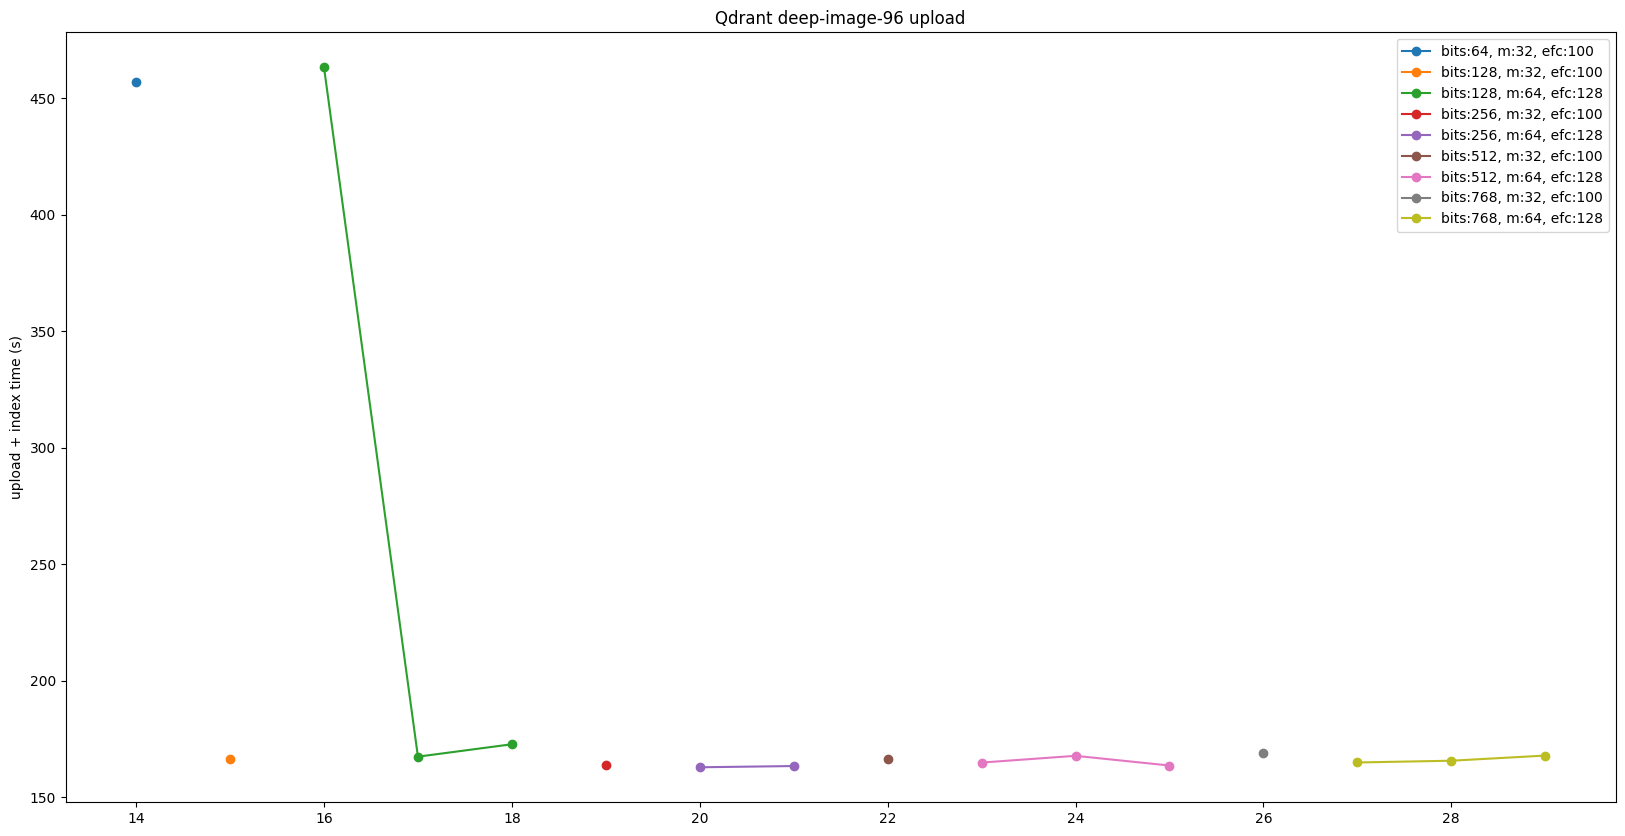

In [112]:
fig, ax = plt.subplots(figsize=(20,10))
tmp = gsi_upload_df.copy()
search_type = "hnsw"
dim = 96
tmp = tmp[(tmp.searchType == search_type) & (tmp.dim == dim)]
configs = tmp.groupby(['nbits', 'm', 'efConstruction']).count().index.to_list()
for nbits, m, efc in configs:
    x = tmp.copy()
    x = x[(x.nbits == nbits) & (x.m == m) & (x.efConstruction == efc)]
    plt.plot(x.total_time,'-o', label=f"bits:{nbits}, m:{m}, efc:{efc}")
ax.legend()
ax.set_title("Qdrant deep-image-96 upload")
ax.set_ylabel("upload + index time (s)")
fig.show()

## weaviate upload

In [5]:
weaviate_upload = [x for x in weaviate_files if "upload" in x]
columns = ['dataset', 'dim', 'efConstruction', 'maxConnections', 'post_upload', 'upload_time', 'total_time', 'latencies']
weaviate_upload_df = pd.DataFrame(columns=columns)
for fname in weaviate_upload:
    ret = pd.read_json(fname).fillna(method='bfill', axis=1).iloc[:, 0].to_dict()
    ret.update(ret.pop('vectorIndexConfig'))
    tmp = fname.split('-')
    if tmp[6].isnumeric():
        ret['dim'], ret['dataset'] = tmp[6], tmp[5]
    else:
        ret['dim'], ret['dataset'] = tmp[7], f"{tmp[5]}-{tmp[6]}"
    weaviate_upload_df.loc[len(weaviate_upload_df), :] = ret
weaviate_upload_df = weaviate_upload_df.astype({'dim': 'int', 'efConstruction': 'int', 'maxConnections': 'int', 'total_time': 'float', 'upload_time':'float'})

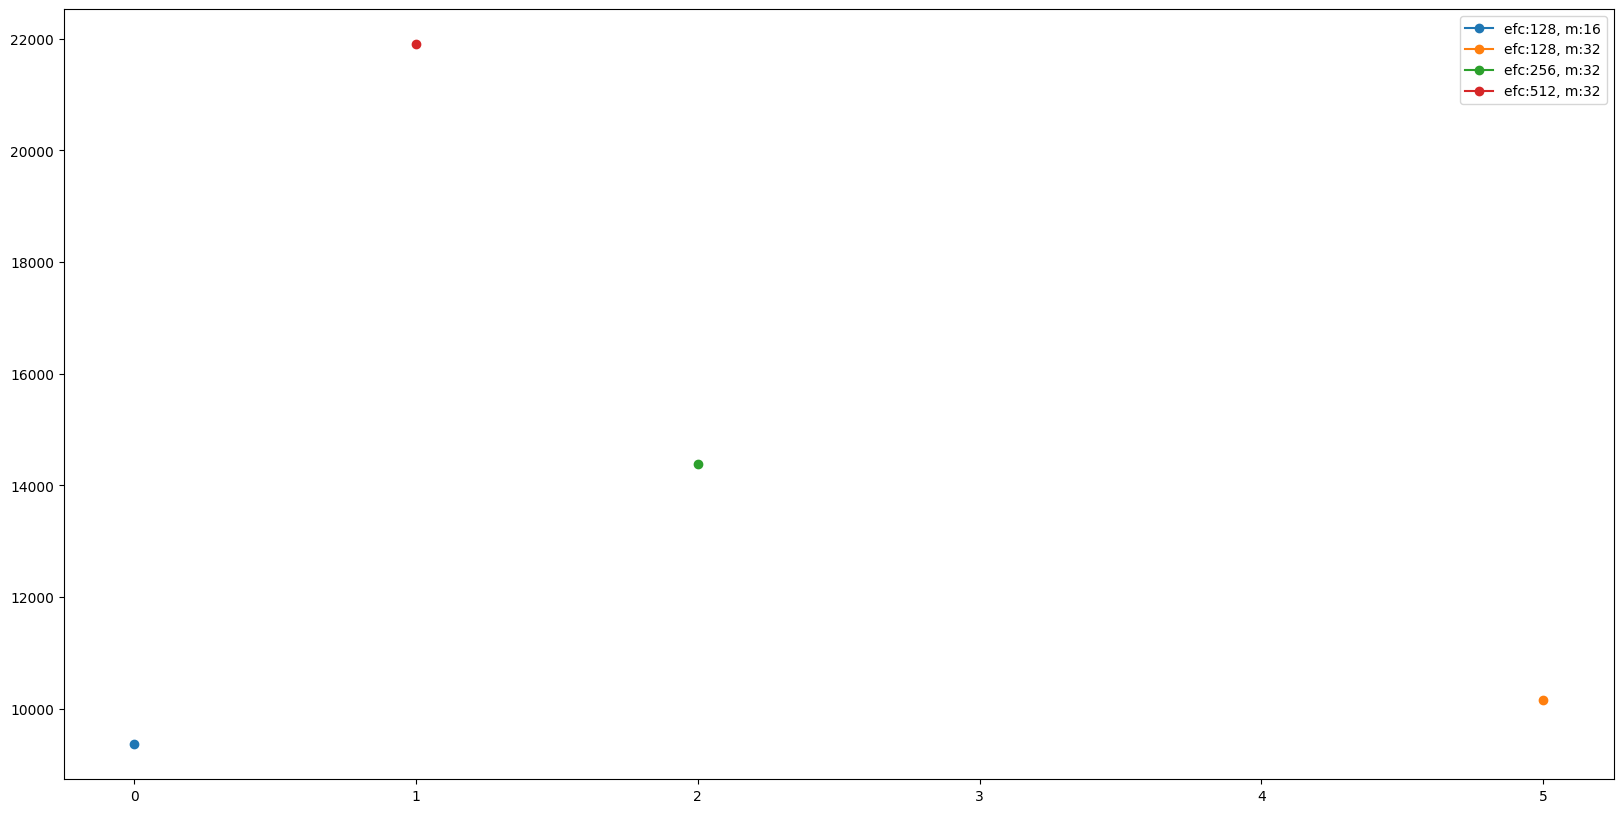

In [7]:
fig, ax = plt.subplots(figsize=(20,10))
dim = 96
tmp = weaviate_upload_df.copy()
tmp = tmp[tmp.dim == dim]
configs = tmp.groupby(['efConstruction', 'maxConnections']).count().index.to_list()
for efc, m in configs:
    x = tmp.copy()
    x = x[(x.efConstruction == efc) & (x.maxConnections == m)]
    plt.plot(x.upload_time, '-o', label=f"efc:{efc}, m:{m}")
ax.legend()
fig.show()

## GIST

In [29]:
import h5py
f = h5py.File("./datasets/gist-960-euclidean/gist-960-euclidean.hdf5")
f['train'][:].shape

(1000000, 960)

In [9]:
gist_gsi = [x for x in search_files if "gsi" in x and "gist" in x]
gist_gsi_df = []
for fname in gist_gsi:
    gist_gsi_df.append(parse_gsi_search(fname))
gist_gsi_df = pd.DataFrame(gist_gsi_df).sort_values(['search_type', 'nbits']).reset_index(drop=True)
gist_gsi_df.head()

,vdb,search_type,nbits,dataset,dim,m,efc,ef,total_time,mean_time,mean_precisions,std_time,min_time,max_time,rps,p95_time,p99_time,precisions,latencies
0,gsi,clusters,128,gist,960,None,None,None,48.063374,0.047750,0.0002,0.007693,0.034795,0.136817,20.805863,0.066022,0.076004,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.05775153590366244, 0.051058078184723854, 0...."
1,gsi,clusters,128,gist,960,None,None,None,45.994533,0.045733,0.0002,0.005255,0.036948,0.121696,21.741714,0.049755,0.060300,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.05188303207978606, 0.0626854570582509, 0.04..."
2,gsi,clusters,128,gist,960,None,None,None,50.148714,0.049830,0.0002,0.010004,0.034782,0.135705,19.940691,0.072074,0.088755,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.04644580511376262, 0.042564600706100464, 0...."
3,gsi,clusters,256,gist,960,None,None,None,48.670978,0.048394,0.0002,0.008969,0.034708,0.184943,20.546125,0.071170,0.079125,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.07867293292656541, 0.04751240508630872, 0.0..."
4,gsi,clusters,256,gist,960,None,None,None,50.534224,0.050217,0.0002,0.009194,0.035026,0.177719,19.788569,0.067806,0.086033,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.05126098310574889, 0.04900113865733147, 0.0..."


In [10]:
gist_weav = [x for x in search_files if "weaviate" in x and "gist" in x]
gist_weav_df = []
for fname in gist_weav:
    gist_weav_df.append(parse_weav_search(fname))
gist_weav_df = pd.DataFrame(gist_weav_df).sort_values(by=['m', 'efc', 'ef']).reset_index(drop=True)
gist_weav_df.head()

,vdb,m,efc,dataset,dim,ef,parallel,total_time,mean_time,mean_precisions,std_time,min_time,max_time,rps,p95_time,p99_time,precisions,latencies
0,weaviate,32,256,gist,960,64,100,1.645596,0.149511,0.80394,0.089423,0.031900,0.326474,607.682548,0.296498,0.307695,"[0.95, 0.92, 0.91, 0.75, 0.76, 0.7, 0.91, 0.63...","[0.04310226999223232, 0.052908726036548615, 0...."
1,weaviate,32,256,gist,960,64,2,12.195882,0.024048,0.80394,0.003066,0.016226,0.057756,81.994890,0.027881,0.030384,"[0.98, 0.9, 0.92, 0.91, 0.64, 0.94, 0.8, 0.7, ...","[0.01981774903833866, 0.020278254058212042, 0...."
2,weaviate,32,256,gist,960,64,8,2.798468,0.021855,0.80394,0.004186,0.013312,0.052291,357.338409,0.028135,0.040020,"[0.98, 0.8, 0.91, 0.64, 0.9, 0.92, 0.94, 0.7, ...","[0.021411050111055374, 0.02031994378194213, 0...."
3,weaviate,32,256,gist,960,64,4,5.571686,0.021828,0.80394,0.002733,0.016502,0.039262,179.478883,0.026683,0.030322,"[0.9, 0.98, 0.92, 0.91, 0.64, 0.8, 0.7, 0.94, ...","[0.01993103977292776, 0.025444423779845238, 0...."
4,weaviate,32,256,gist,960,64,1,25.258565,0.025020,0.80394,0.002583,0.016102,0.042556,39.590531,0.028386,0.031882,"[0.98, 0.9, 0.92, 0.91, 0.64, 0.94, 0.8, 0.7, ...","[0.026619466952979565, 0.029629402328282595, 0..."


In [11]:
gist_qdrant = [x for x in search_files if "qdrant" in x and "gist" in x]
gist_qdrant_df = []
for fname in gist_qdrant:
    gist_qdrant_df.append(parse_qdrant_search(fname))
gist_qdrant_df = pd.DataFrame(gist_qdrant_df).sort_values(by=['m', 'efc', 'hnsw_ef']).reset_index(drop=True)
gist_qdrant_df.head()

,vdb,m,efc,dataset,dim,mode,hnsw_ef,parallel,total_time,mean_time,mean_precisions,std_time,min_time,max_time,rps,p95_time,p99_time,precisions,latencies
0,qdrant,32,256,gist,960,mmap,64,8,3.324019,0.023794,0.90643,0.055237,0.003987,0.556194,300.840605,0.162605,0.211237,"[0.98, 0.94, 0.99, 0.98, 0.99, 0.81, 0.99, 0.8...","[0.010221406817436218, 0.010693768039345741, 0..."
1,qdrant,32,256,gist,960,rps,64,1,5.850815,0.005692,0.89705,0.003227,0.003624,0.100570,170.916357,0.007663,0.010360,"[0.99, 0.95, 0.99, 0.93, 0.78, 0.95, 0.81, 0.8...","[0.10057019209489226, 0.01794531289488077, 0.0..."
2,qdrant,32,256,gist,960,default,64,1,7.116376,0.006935,0.89987,0.004521,0.003883,0.125822,140.520968,0.010873,0.019541,"[0.99, 0.97, 0.95, 0.9, 0.82, 0.98, 0.85, 0.85...","[0.1258217440918088, 0.01730305701494217, 0.00..."
3,qdrant,32,256,gist,960,default,64,8,3.832132,0.027582,0.89987,0.065795,0.003837,0.652650,260.951378,0.204901,0.265054,"[0.9, 0.82, 0.97, 0.93, 0.97, 0.96, 0.82, 0.92...","[0.012130039744079113, 0.014852811582386494, 0..."
4,qdrant,32,256,gist,960,mmap,64,2,4.944085,0.009452,0.90643,0.020497,0.003731,0.340712,202.261909,0.025090,0.099056,"[0.99, 0.98, 0.94, 0.92, 0.99, 0.79, 0.89, 0.9...","[0.010185007005929947, 0.008002339862287045, 0..."


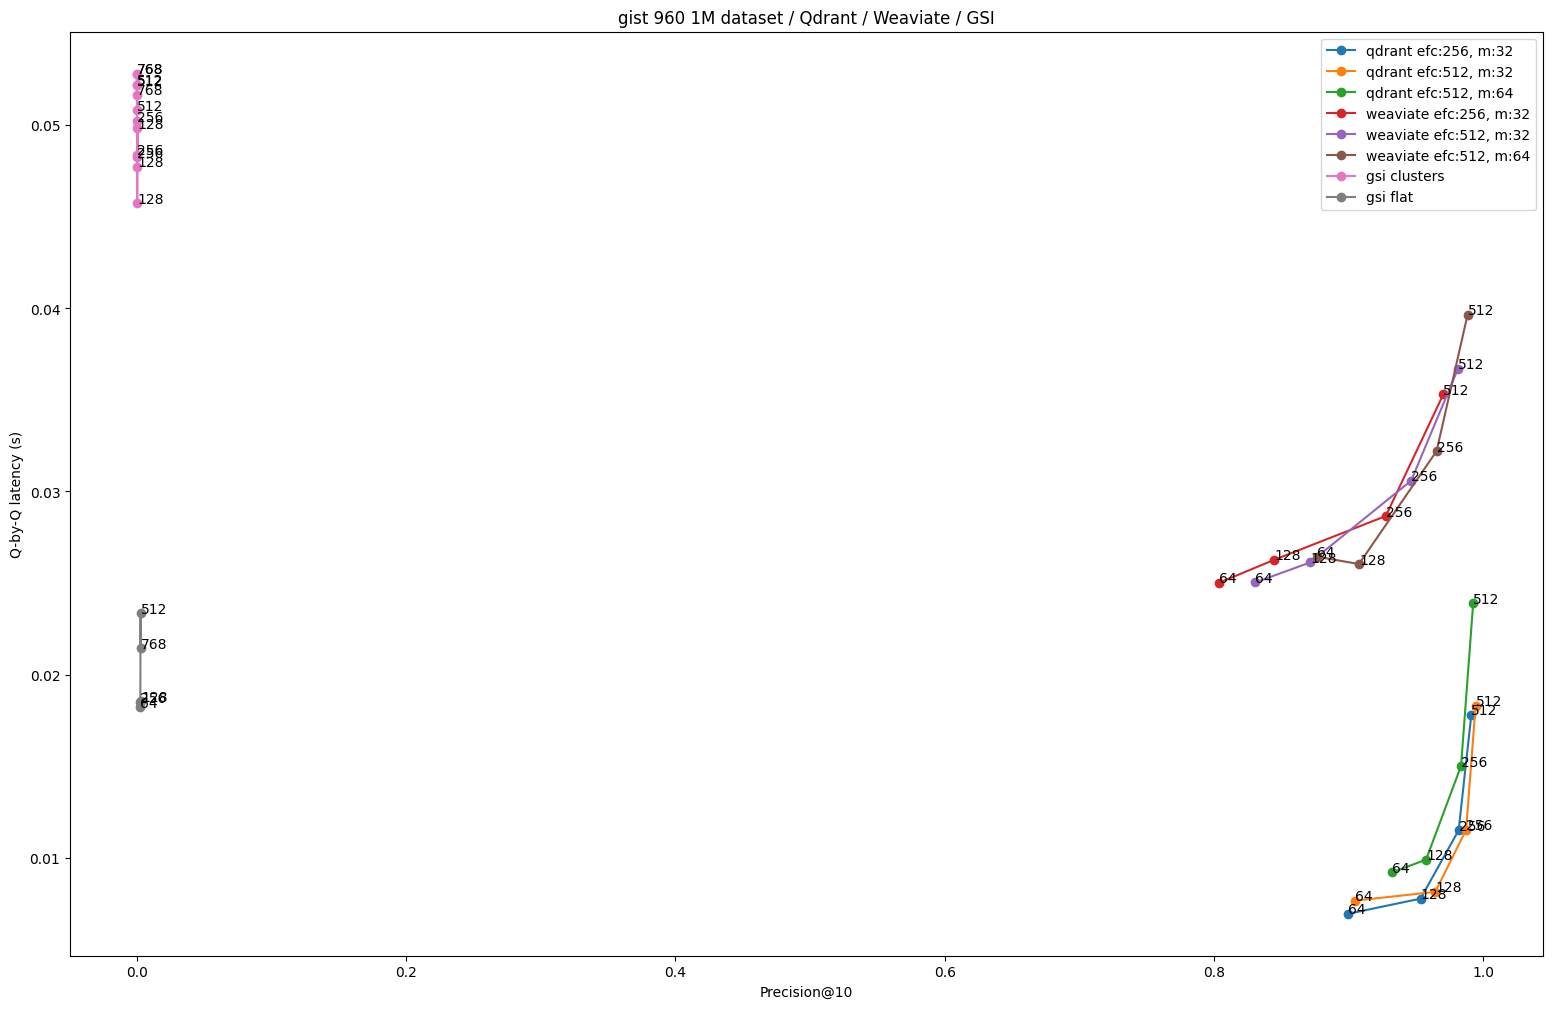

In [12]:

fig, ax = plt.subplots(figsize=(19,12))
mode = "default"
parallels = [1]
configs = gist_qdrant_df.groupby(['m', 'efc']).count().index.to_list()
for m, efc in configs:
    tmp = gist_qdrant_df[(gist_qdrant_df.m == m) & (gist_qdrant_df.efc == efc) & (gist_qdrant_df.parallel.isin(parallels))]
    tmp = tmp[tmp['mode'] == mode]
    plt.plot(tmp.mean_precisions, tmp.mean_time, '-o', label=f"qdrant efc:{efc}, m:{m}")
    for x, y, z in zip(tmp.mean_precisions, tmp.mean_time, tmp.hnsw_ef):
        plt.annotate(z, (x, y))

for m, efc in configs:
    tmp = gist_weav_df[(gist_weav_df.m == m) & (gist_weav_df.efc == efc) & (gist_weav_df.parallel.isin(parallels))]
    plt.plot(tmp.mean_precisions, tmp.mean_time, '-o', label=f"weaviate efc:{efc}, m:{m}")
    for x, y, z in zip(tmp.mean_precisions, tmp.mean_time, tmp.ef):
        plt.annotate(z, (x, y))

for search_type in gist_gsi_df.search_type.unique():
    tmp = gist_gsi_df[gist_gsi_df.search_type == search_type]
    plt.plot(tmp.mean_precisions, tmp.mean_time, '-o', label=f"gsi {search_type}")
    for x, y, z in zip(tmp.mean_precisions, tmp.mean_time, tmp.nbits):
        plt.annotate(z, (x, y))

ax.legend()
ax.set_title("gist 960 1M dataset / Qdrant / Weaviate / GSI")
ax.set_xlabel("Precision@10")
ax.set_ylabel("Q-by-Q latency (s)")
fig.show()

## Deep Image 96 (10M)